In [69]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [111]:
torch.backends.cudnn.derterministic =True
torch.backends.cudnn.benchmark = True

In [3]:
class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            "val"  : transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
    def __call__(self,img,phase="train"):
        return self.data_transform[phase](img)
    
    

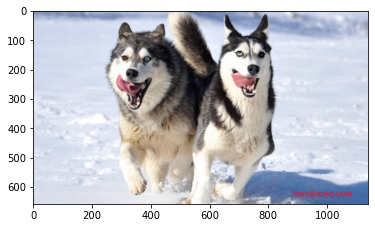

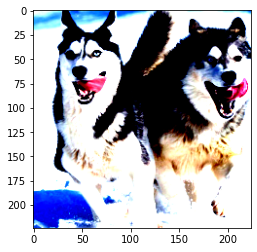

In [4]:
img_file_path = "./data/husky.jpg"
img=Image.open(img_file_path)

plt.imshow(img)
plt.show()

size = 224
mean=[0.485, 0.456, 0.406]
std =[0.229, 0.224, 0.225]

trans= ImageTransform(size,mean,std)
transed_img= trans(img,"train")
transed_img=transed_img.numpy().transpose(1,2,0).clip(0,1)

plt.imshow(transed_img)
plt.show()



In [5]:
def make_datapath_list(phase="train"):
    root_path=".\\data\\hymenoptera_data\\"
    
    target_path=root_path+phase+"\\**\\*.jpg"
    
    path_list =[]
    for path in glob.glob(target_path): 
        path_list.append(path)
    return path_list

In [6]:
train_list=make_datapath_list(phase="train")
val_list=make_datapath_list(phase="val")

print(int(val_list[110].split('\\')[4]=='bees'))


1


In [50]:
class Mydataset(data.Dataset):
    def __init__(self,file_list,transform=None,phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase     = phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self,index):
        img_path=self.file_list[index]
        img = Image.open(img_path)
        
        trans_img = self.transform(img,self.phase)
        label = int(img_path.split('\\')[4] == 'bees')
        return trans_img , label
    

In [8]:
train_dataset = Mydataset(train_list,transform = ImageTransform(size,mean,std),phase="train")
val_dataset = Mydataset(val_list,transform = ImageTransform(size,mean,std),phase="val")

image shape with index 30 is torch.Size([3, 224, 224]) have label 0


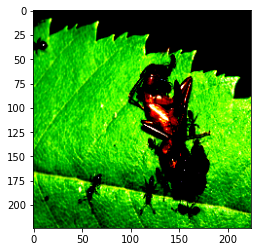

In [59]:
index = 30
img , label = train_dataset.__getitem__(index)
print("image shape with index {} is {} have label {}".format(index,img.shape,label))

img =img.numpy().transpose(1,2,0).clip(0,1)
plt.imshow(img)
plt.show()


In [133]:
batch_size = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size,shuffle=True)
dataloader_dict= {
    "train": train_dataloader,
    "val"  : val_dataloader
}

In [134]:
batch_iterator = iter(dataloader_dict["val"])
inputs,label = next(batch_iterator)

In [230]:
print(inputs.shape )
print( label)

torch.Size([64, 3, 224, 224])
tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])


# end of part 1 (dataset module prepare)


# Network

In [135]:
use_pretrain= True
net = models.vgg16(pretrained=use_pretrain,progress=True)
net=net
print(net)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# change final layer classifier[6] to 2 output

In [136]:
net.classifier[6]=nn.Linear(4096,2)
print(net)
net=net.train()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Loss and optimizer

In [137]:
loss = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum = 0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
parameter_to_update = []
update_params_name = ["classifier.6.weight","classifier.6.bias"]
for name , param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        parameter_to_update.append(param)
        print(name)
#         print(param.shape,param)
        
    else:
        param.requires_grad = False
#         print(name)
#         print(param.shape,param)
print(parameter_to_update)
        

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[ 0.0114, -0.0146,  0.0107,  ..., -0.0107, -0.0099, -0.0015],
        [-0.0070,  0.0027,  0.0104,  ...,  0.0112, -0.0140,  0.0097]],
       requires_grad=True), Parameter containing:
tensor([-0.0085,  0.0027], requires_grad=True)]


In [126]:
optimizer = optim.SGD(parameter_to_update,lr=0.01,momentum = 0.9)
# optimizer = optim.SGD
#detach last layer W and b params and apply SGD

# there are bugs need to fix later

In [141]:
def train_model (net,dataloader_dict,loss,optimizer,num_epochs,device):
    net = net.to(device)
    for epochs in range(1,num_epochs):
        print("Epoch{}/{}".format(epochs,num_epochs))
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
            epoch_loss, epoch_correct = 0.0 , 0
            
            if(epochs == 0 ) and (phase == "train"):
                continue
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs, labels =inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    losses    = loss(outputs,labels)
                    _, predicts = torch.max(outputs,1)

                    if phase == "train":
                        losses.backward()
                        optimizer.step()
                epoch_loss += losses.item()/inputs.size(0)
                epoch_correct += torch.sum(predicts==labels.data)

            epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_correct/len(dataloader_dict[phase].dataset)

            print("{} Loss {:.4f} Acc: {:4f}".format(phase, epoch_loss, epoch_accuracy))


In [142]:

num_epochs = 2
train_model(net,dataloader_dict,loss,optimizer,num_epochs,device)

Epoch1/2


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 20.64it/s]


train Loss 0.0988 Acc: 0.909465


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.83it/s]

val Loss 0.0467 Acc: 0.960784
